In [1]:
from ase.io import read
from ase.visualize.plot import plot_atoms
from abtem import Potential
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
from DM1dCalc.multislice import multislice, multislice_1d

In [2]:
sto_3bc = read('../structures/STO3bc.cif')
sto_3bc = sto_3bc.repeat((1, 3, 1))
energy = 200e3  # in eV
sampling = 0.065  # in Angstrom

potential = Potential(
    sto_3bc,
    sampling=sampling,
    slice_thickness=1,
    projection="finite"
).build().array
potential = np.array(potential)
height, width, depth = potential.shape
potential_1d = np.mean(potential, axis=1)
ew_1d = multislice_1d(np.array(potential_1d),
                          energy=energy,
                          sampling=sampling,
                          slice_thickness=1,
                          device='cpu')

100%|██████████| 32/32 [00:00<00:00, 16170.81it/s]


Peaks found at indices: [ 30  60  90 121 151]
Peak values: [1.2542282 1.2509776 1.2510179 1.2509837 1.254226 ]
Peak positions (z): [1.95  3.9   5.85  7.865 9.815]
Peak positions (z) in Angstroms: [1.950e+10 3.900e+10 5.850e+10 7.865e+10 9.815e+10]


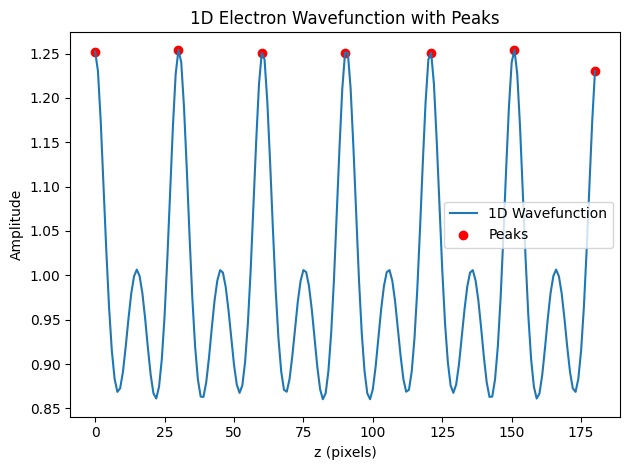

In [3]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(np.abs(ew_1d), height=1.1)
print("Peaks found at indices:", peaks)
print("Peak values:", np.abs(ew_1d[peaks]))
print("Peak positions (z):", peaks * sampling)
print("Peak positions (z) in Angstroms:", peaks * sampling * 1e10)
posn = [0, *peaks, len(ew_1d)-1]
plt.plot(np.abs(ew_1d), label='1D Wavefunction')
plt.scatter(np.array(posn), np.abs(ew_1d[np.array(posn)]), color='red', label='Peaks')
plt.title('1D Electron Wavefunction with Peaks')
plt.xlabel('z (pixels)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

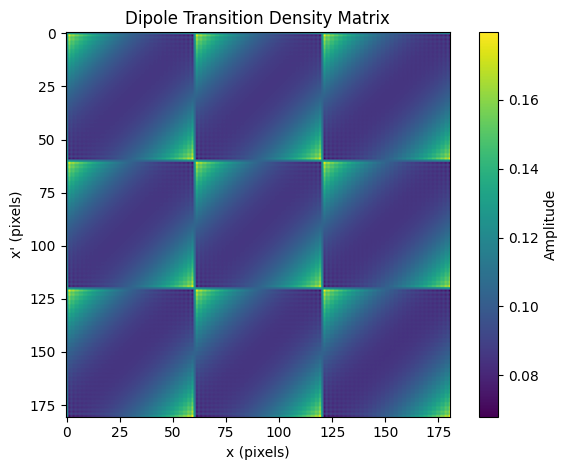

In [4]:
from DM1dCalc.ionization import dipole_transition_potential, dipole_transition_potential_1d

posn = list(np.linspace(0, len(ew_1d)-1, 4, dtype=int))[:-1]
#posn = [0, ]
#posn = [len(ew_1d) // 2, ]  # Center position for dipole transition
loss = 456
pot_x, pot_z = dipole_transition_potential_1d(
    energy=energy,
    loss=loss,
    sampling=sampling,
    shape = len(ew_1d),
    posn=posn)
dm_transition = np.outer(pot_x, pot_x.conj()) + np.outer(pot_z, pot_z.conj())
plt.imshow(np.abs(dm_transition))
plt.title('Dipole Transition Density Matrix')
plt.xlabel('x (pixels)')
plt.ylabel("x' (pixels)")
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()

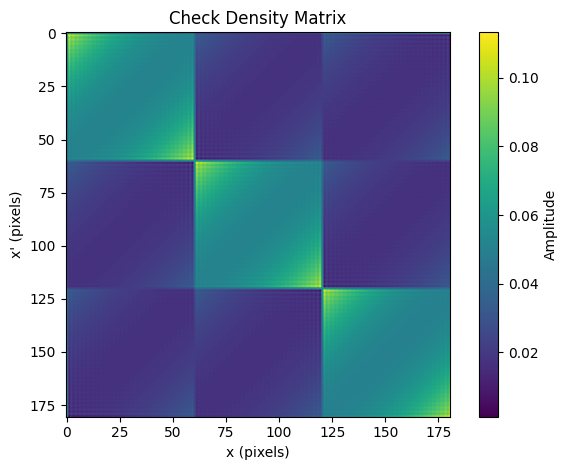

In [5]:
from DM1dCalc.core_convert import energy2wavelengh
import scipy

shape = len(ew_1d)
k = np.fft.fftfreq(shape, sampling)
kp = np.fft.fftfreq(shape, sampling)    
k0 = 1 / energy2wavelengh(energy)
kn = 1 / energy2wavelengh(energy - loss)
kz = k0 - kn
dm_transition_check = np.zeros((shape, shape), dtype=complex)
K, Kp = np.meshgrid(k, kp, indexing='ij')
Sq = (-K*Kp + kz**2)/((K**2+kz**2)*(Kp**2+kz**2))
for pos in posn:
    dm_transition_check = dm_transition_check + np.exp(-2j*np.pi*(K*pos+Kp*pos)*sampling) * Sq
dm_transition_check = scipy.fft.ifft2(dm_transition_check)
#dm_transition_check = scipy.fft.ifft2(Sq)
plt.imshow(np.abs(dm_transition_check), cmap='viridis')
plt.title('Check Density Matrix')
plt.xlabel('x (pixels)')
plt.ylabel("x' (pixels)")
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()

c:\Users\lenovo\OneDrive\桌面\SR_EELS\EFTEM_reconstruct\Github_files\DM1dCalc-master\demonstrations\..\DM1dCalc\multislice.py:221: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  transitions = torch.tensor(transitions, dtype=torch.complex64, device=device)


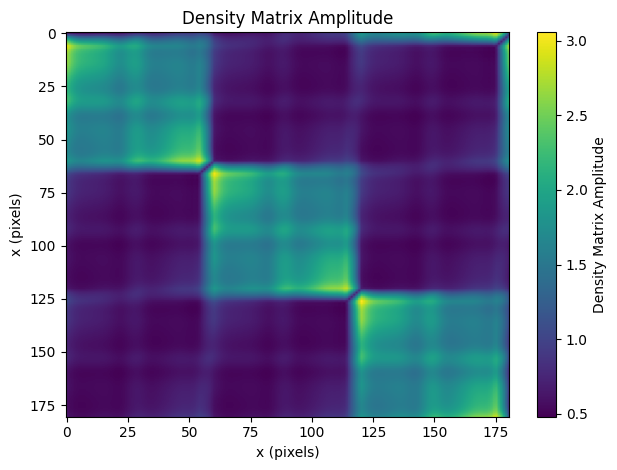

In [6]:
from DM1dCalc.multislice import density_matrix_multislice

density_matrix = density_matrix_multislice(
    potential_1d=potential_1d,
    transitions=[dm_transition_check],
    energy=energy,
    sampling=sampling,
    slice_thickness=1,
    transition_mode="matrix"
)

plt.imshow(np.abs(density_matrix), aspect='auto', cmap='viridis')
plt.colorbar(label='Density Matrix Amplitude')
plt.title('Density Matrix Amplitude')
plt.xlabel('x (pixels)')
plt.ylabel('x (pixels)')
plt.tight_layout()
plt.show()

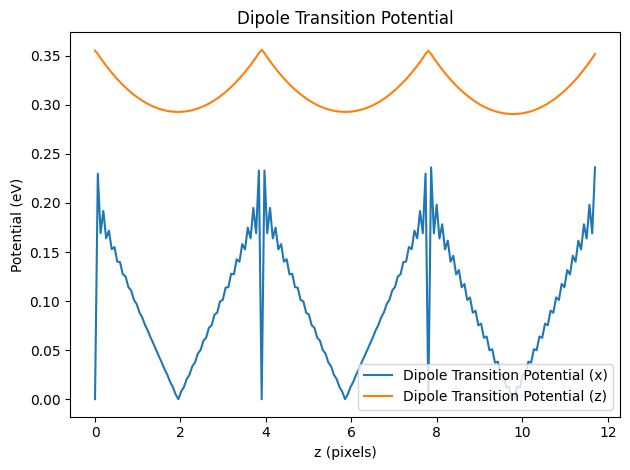

In [7]:
from DM1dCalc.ionization import dipole_transition_potential, dipole_transition_potential_1d
from DM1dCalc.multislice import density_matrix_multislice

posn = list(np.linspace(0, len(ew_1d)-1, 4, dtype=int))[:-1]

loss = 456

pot_x, pot_z = dipole_transition_potential_1d(
    energy=energy,
    loss=loss,
    sampling=sampling,
    shape = len(ew_1d),
    posn=posn)

rx = np.arange(len(pot_x)) * sampling
plt.plot(rx, np.abs(pot_x), label='Dipole Transition Potential (x)')
plt.plot(rx, np.abs(pot_z), label='Dipole Transition Potential (z)')
plt.title('Dipole Transition Potential')
plt.xlabel('z (pixels)')
plt.ylabel('Potential (eV)')
plt.legend()
plt.tight_layout()
plt.show()

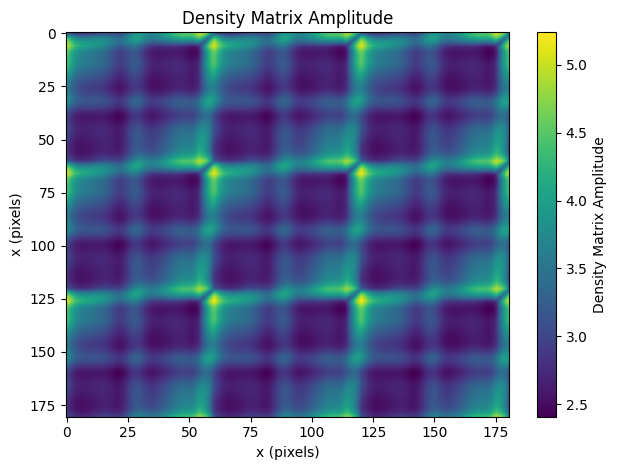

In [8]:
from DM1dCalc.multislice import density_matrix_multislice

density_matrix = density_matrix_multislice(
    potential_1d=potential_1d,
    transitions=[pot_x, pot_z],
    energy=energy,
    sampling=sampling,
    slice_thickness=1,
    transition_mode="potential"
)
plt.imshow(np.abs(density_matrix), aspect='auto', cmap='viridis')
plt.colorbar(label='Density Matrix Amplitude')
plt.title('Density Matrix Amplitude')
plt.xlabel('x (pixels)')
plt.ylabel('x (pixels)')
plt.tight_layout()
plt.show()